This notebook investigates the internal wave generation mechanism proposed by Gargett 1977 at Boundary Pass. Do we observe these features in the model as well?



In [1]:
import netCDF4 as nc
import numpy as np
from salishsea_tools import viz_tools, tidetools
from nowcast import analyze

import matplotlib.pyplot as plt
import os
import glob

%matplotlib inline

In [2]:
grid = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
bathy = grid.variables['Bathymetry'][:]
X = grid.variables['nav_lon'][:]
Y = grid.variables['nav_lat'][:]

[250, 350, 300, 400]

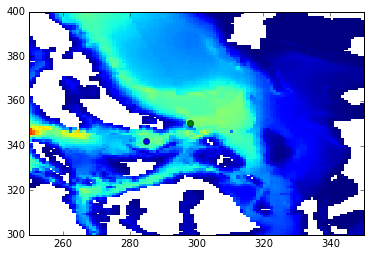

In [3]:
plt.pcolormesh(bathy)
iBP = 285
jBP = 342

iSG = 298
jSG = 350

plt.plot(iBP,jBP,'o')
plt.plot(iSG,jSG,'o')

plt.axis([250,350,300,400])

## Load Data



In [4]:
dmy='17jun15'

path = '/results/SalishSea/nowcast/{}/'.format(dmy)
fT = nc.Dataset(glob.glob(os.path.join(path,'SalishSea_1h_*_grid_T.nc'))[0])
sal = fT.variables['vosaline']
depths = fT.variables['deptht'][:]

fU = nc.Dataset(glob.glob(os.path.join(path,'SalishSea_1h_*_grid_U.nc'))[0])
u = fU.variables['vozocrtx']
u=np.ma.masked_values(u,0)

fV = nc.Dataset(glob.glob(os.path.join(path,'SalishSea_1h_*_grid_V.nc'))[0])
v = fV.variables['vomecrty']
v=np.ma.masked_values(v,0)

#unstagger
u,v = viz_tools.unstagger(u,v)

#rotate
theta = np.pi*29/180
uE = u*np.cos(theta) - v*np.sin(theta)
vN = u*np.sin(theta) +v*np.cos(theta)

del u,v

# Salinity time series at mouth of Boundary Pass

In [5]:
smin, smax, st= 20,30,0.5
slevs = np.arange(smin,smax+st, st)
ts=np.arange(0,24)

(20, 0)

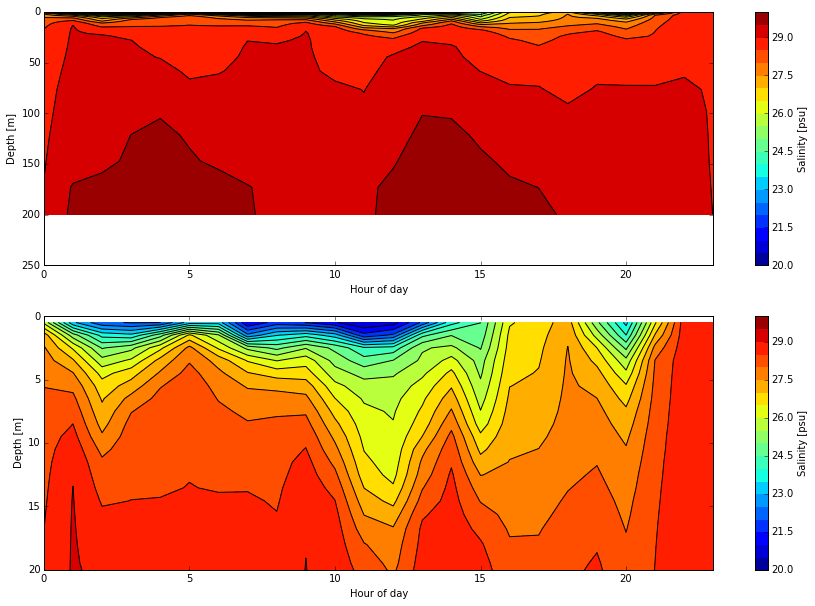

In [6]:
sal_m = np.ma.masked_values(sal[:,:,jSG,iSG],0)
fig,axs = plt.subplots(2,1,figsize=(15,10))
for ax in axs:
    mesh=ax.contourf(ts,depths,sal_m.T,slevs,vmin=smin, vmax=smax)
    ax.contour(ts,depths,sal_m.T,slevs, colors='k')
    cbar=plt.colorbar(mesh,ax=ax)
    cbar.set_label('Salinity [psu]')
    ax.set_ylabel('Depth [m]')
    ax.set_xlabel('Hour of day')
axs[0].set_ylim([250,0])
axs[1].set_ylim([20,0])

It looks like there is a large amplitude wave at about t=11. Can we visualize this wave spatially? Isosurfaces?

# Salinity time series inside of Boundary Pass

(250, 0)

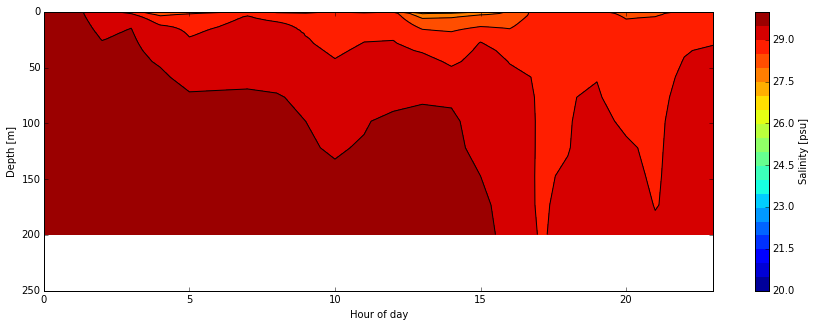

In [7]:
sal_m = np.ma.masked_values(sal[:,:,jBP,iBP],0)
fig,ax = plt.subplots(1,1,figsize=(15,5))
mesh=ax.contourf(ts,depths,sal_m.T,slevs,vmin=smin, vmax=smax)
ax.contour(ts,depths,sal_m.T,slevs, colors='k')
cbar=plt.colorbar(mesh,ax=ax)
cbar.set_label('Salinity [psu]')
ax.set_ylabel('Depth [m]')
ax.set_xlabel('Hour of day')
ax.set_ylim([250,0])

In [8]:
speed = np.sqrt(uE**2+vN**2)
theta = np.arctan2(vN,uE)
theta = np.rad2deg(theta) + 360*(theta <0)
udep =  analyze.depth_average(uE,depths,1)
vdep =  analyze.depth_average(vN,depths,1)

In [9]:
udep=np.expand_dims(udep,1)
vdep=np.expand_dims(vdep,1)
ubc = uE-udep
vbc = vN-vdep
del udep, vdep
kebc = 0.5*(ubc**2 +vbc**2)

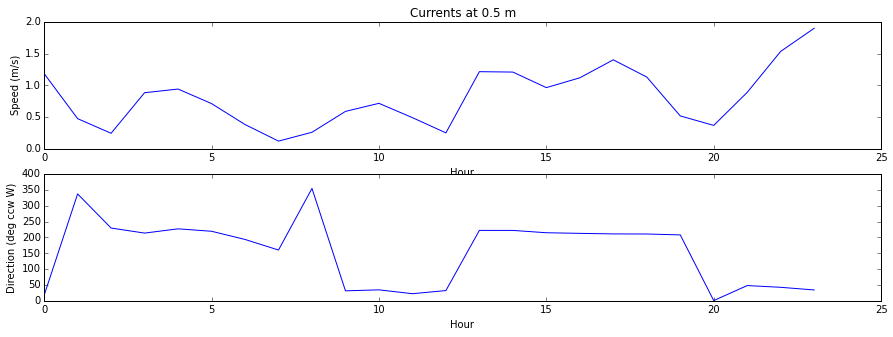

In [10]:
d=0
fig,axs = plt.subplots(2,1,figsize=(15,5))
ax=axs[0]
ax.set_title('Currents at {0:2g} m'.format(depths[d]))
ax.plot(ts,speed[:,d,jBP,iBP])
ax.set_ylabel('Speed (m/s)')
ax.set_xlabel('Hour')
ax=axs[1]
ax.plot(ts,theta[:,d,jBP,iBP])
ax.set_ylabel('Direction (deg ccw W)')
ax.set_xlabel('Hour')

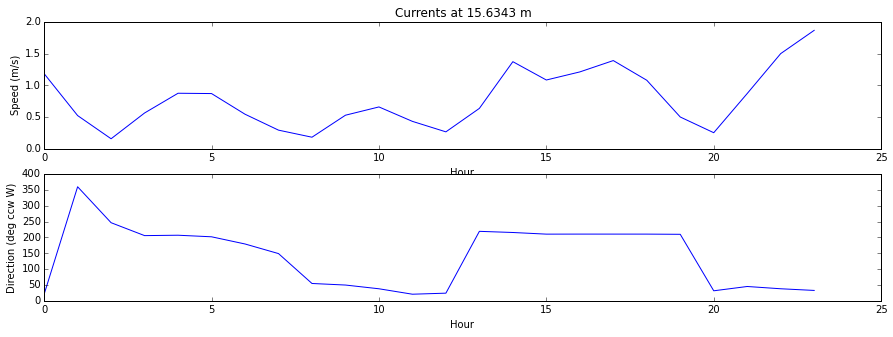

In [11]:
d=15
fig,axs = plt.subplots(2,1,figsize=(15,5))
ax=axs[0]
ax.set_title('Currents at {0:2g} m'.format(depths[d]))
ax.plot(ts,speed[:,d,jBP,iBP])
ax.set_ylabel('Speed (m/s)')
ax.set_xlabel('Hour')
ax=axs[1]
ax.plot(ts,theta[:,d,jBP,iBP])
ax.set_ylabel('Direction (deg ccw W)')
ax.set_xlabel('Hour')

# Animations

In [12]:
from matplotlib import animation

In [13]:
def quiver_salinity(t):
    ax.clear()
    #mesh
    mesh=ax.contourf(X,Y,sal[t,0,:,:],slevs,extend='both')
    #land
    viz_tools.plot_land_mask(ax,grid,coords='map',color='burlywood')
    viz_tools.plot_coastline(ax,grid,coords='map')
    #quivers
    quiver = ax.quiver(X[::st,::st], Y[::st,::st], uE[t,0,::st,::st], vN[t,0,::st,::st],
                       pivot='mid', width=0.005,scale=15, color='white',
                       headwidth=2.5,headlength=2)
    ax.quiverkey(quiver,-122.6,48.9, 1, '1 m/s',
                 coordinates='data', color='white', labelcolor='white')
    
    #title
    ax.set_title(t)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_xlim([-123.5,-122.5])
    ax.set_ylim([48.5,49])
    ax.plot(X[jBP,iBP],Y[jBP,iBP],'o')
    ax.plot(X[jSG,iSG],Y[jSG,iSG],'o')

    
    return mesh

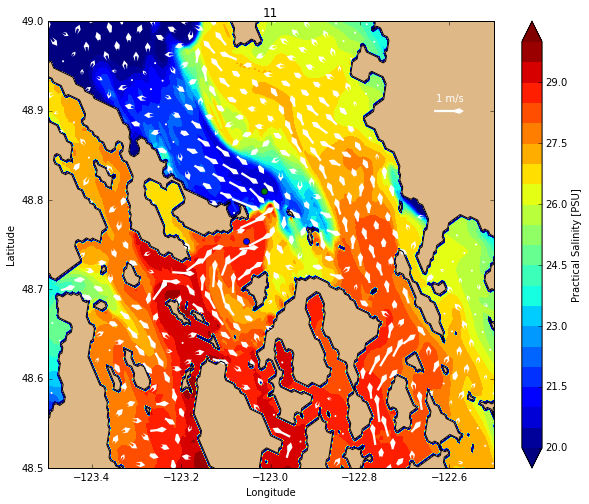

In [14]:
t=11
st=5
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
mesh=quiver_salinity(t)
cbar = plt.colorbar(mesh, ax=ax)
cbar.set_label('Practical Salinity [PSU]')

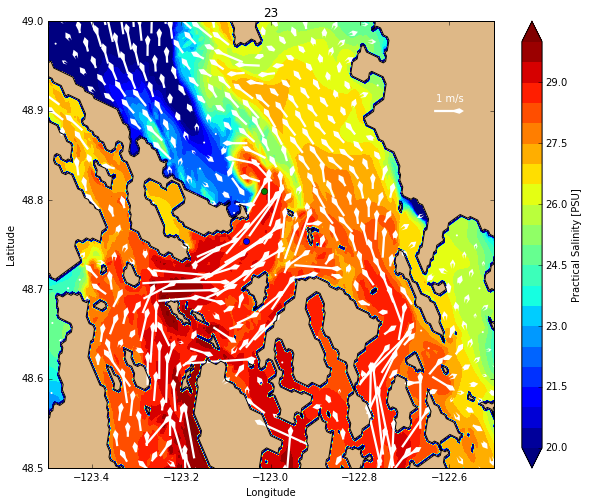

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
mesh=quiver_salinity(0)
cbar = plt.colorbar(mesh, ax=ax)
cbar.set_label('Practical Salinity [PSU]')

#frmaes
framess=ts

#The animation function    
anim = animation.FuncAnimation(fig, quiver_salinity,frames=framess,  blit=True, repeat=False)

#A line that makes it all work
mywriter = animation.FFMpegWriter( fps=3, bitrate=10000)

#Save in current folder
anim.save('surface_currents-{}.mp4'.format(dmy),writer=mywriter)

In [16]:
def salinity_depth(t):
    ax.clear()
    mesh=ax.contourf(np.arange(898),depths,sal[t,:,:,iSG],slevs,vmin=smin, vmax=smax)
    ax.contour(np.arange(898),depths,sal[t,:,:,iSG], slevs,colors='k')
    ax.set_xlim([300,400])
    ax.set_ylim([100,0])
    ax.plot([jSG,jSG],[400,0],'--k')
    ax.set_title(t)
    return mesh

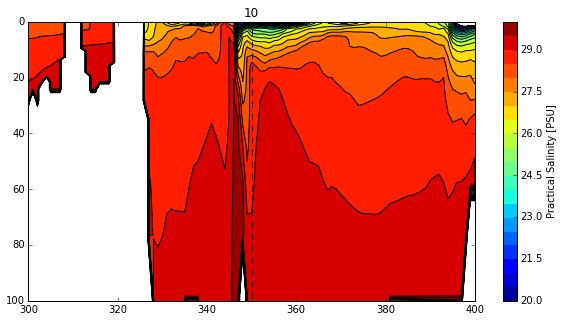

In [17]:
t=10
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
mesh=salinity_depth(t)
cbar = plt.colorbar(mesh, ax=ax)
cbar.set_label('Practical Salinity [PSU]')

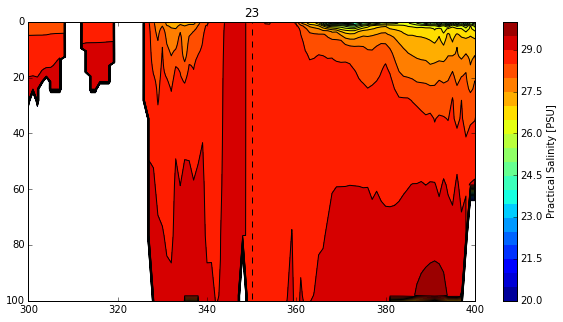

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
mesh = salinity_depth(0)
cbar = plt.colorbar(mesh, ax=ax)
cbar.set_label('Practical Salinity [PSU]')

#frmaes
framess=ts

#The animation function    
anim = animation.FuncAnimation(fig, salinity_depth,frames=framess,  blit=True, repeat=False)

#A line that makes it all work
mywriter = animation.FFMpegWriter( fps=3, bitrate=10000)

#Save in current folder
anim.save('SOG-waves-{}.mp4'.format(dmy),writer=mywriter)

In [19]:
def baroclinic_ke(t):
    ax.clear()
    mesh=ax.contourf(np.arange(897),depths,kebc[t,:,:,iSG],kelevs,vmin=kemin, vmax=kemax,cmap='hot')
    ax.set_xlim([300,400])
    ax.set_ylim([100,0])
    ax.plot([jSG,jSG],[400,0],'--w')
    ax.set_title(t)
    return mesh

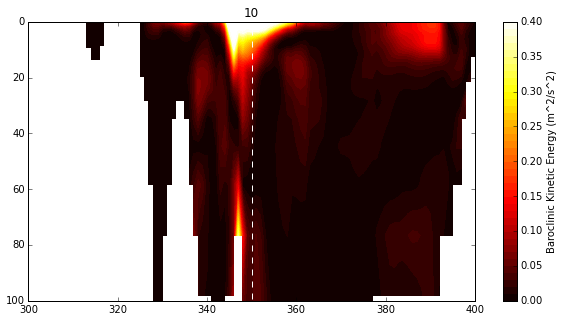

In [20]:
t=10
kemin, kemax, st = 0,.4, .01
kelevs = np.arange(kemin,kemax+st,st)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
mesh=baroclinic_ke(t)
cbar = plt.colorbar(mesh, ax=ax)
cbar.set_label('Baroclinic Kinetic Energy (m^2/s^2)')

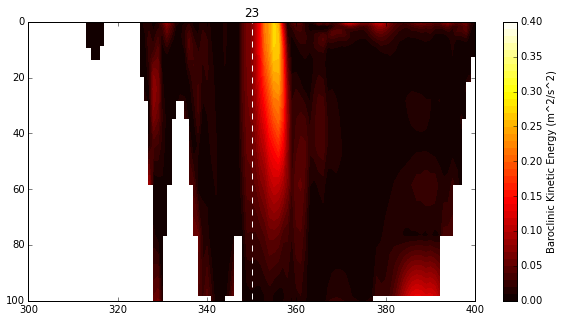

In [21]:

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
mesh = baroclinic_ke(0)
cbar = plt.colorbar(mesh, ax=ax)
cbar.set_label('Baroclinic Kinetic Energy (m^2/s^2)')

#frmaes
framess=ts

#The animation function    
anim = animation.FuncAnimation(fig, baroclinic_ke,frames=framess,  blit=True, repeat=False)

#A line that makes it all work
mywriter = animation.FFMpegWriter( fps=3, bitrate=10000)

#Save in current folder
anim.save('SOGke-{}.mp4'.format(dmy),writer=mywriter)